# Advanced LFP

Here we will demonstrate the diverse ways the different LFP proxies can be computed and compare them to each other.

In [1]:
# preamble:
import brian2.only as b2
from brian2 import np
import matplotlib.pyplot as plt
import cleo
from cleo import ephys
import cleo.utilities

# the default cython compilation target isn't worth it for
# this trivial example
b2.prefs.codegen.target = "numpy"
b2.seed(18010601)
np.random.seed(18010601)
rng = np.random.default_rng(18010601)

cleo.utilities.style_plots_for_docs()

# colors
c = {
    "light": "#df87e1",
    "main": "#C500CC",
    "dark": "#8000B4",
    "exc": "#d6755e",
    "inh": "#056eee",
    "accent": "#36827F",
}

## Network setup

First we need a point neuron simulation to approximate the LFP for.
Here we adapt a balanced E/I network implementation [from the Neuronal Dynamics textbook](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/brunel_model/LIF_spiking_network.html#simulate_brunel_network), using some parameters from [Mazzoni, Lindén et al., 2015](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004584).

In [2]:
n_exc = 800
n_inh = None  # None = N_excit / 4
n_ext = 100
connection_probability = 0.2
w0 = 0.07 * b2.nA
g = 4
synaptic_delay = 1 * b2.ms
poisson_input_rate = 220 * b2.Hz
w_ext = 0.091 * b2.nA
v_rest = -70 * b2.mV
v_reset = -60 * b2.mV
firing_threshold = -50 * b2.mV
membrane_time_scale = 20 * b2.ms
Rm = 100 * b2.Mohm
abs_refractory_period = 2 * b2.ms

if n_inh is None:
    n_inh = int(n_exc / 4)
N_tot = n_exc + n_inh
if n_ext is None:
    n_ext = int(n_exc * connection_probability)
if w_ext is None:
    w_ext = w0

J_excit = w0
J_inhib = -g * w0

lif_dynamics = """
    dv/dt = (-(v-v_rest) + Rm*(I_exc + I_ext + I_gaba)) / membrane_time_scale : volt (unless refractory)
    I_gaba : amp
    I_exc : amp
    I_ext : amp
"""

neurons = b2.NeuronGroup(
    N_tot,
    model=lif_dynamics,
    threshold="v>firing_threshold",
    reset="v=v_reset",
    refractory=abs_refractory_period,
    method="linear",
)
neurons.v = (
    np.random.uniform(
        v_rest / b2.mV, high=firing_threshold / b2.mV, size=(n_exc + n_inh)
    )
    * b2.mV
)
cleo.coords.assign_coords_rand_cylinder(
    neurons, (0, 0, 700), (0, 0, 900), 250, unit=b2.um
)

exc = neurons[:n_exc]
inh = neurons[n_exc:]

syn_eqs = """
    dI_syn_syn/dt = (s - I_syn_syn)/tau_dsyn : amp (clock-driven)
    I_TYPE_post = I_syn_syn : amp (summed)
    ds/dt = -s/tau_rsyn : amp (clock-driven)
"""

exc_synapses = b2.Synapses(
    exc,
    target=neurons,
    model=syn_eqs.replace("TYPE", "exc"),
    on_pre="s += J_excit",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.4 * b2.ms, "tau_dsyn": 2 * b2.ms},
)
exc_synapses.connect(p=connection_probability)

inh_synapses = b2.Synapses(
    inh,
    target=neurons,
    model=syn_eqs.replace("TYPE", "gaba"),
    on_pre="s += J_inhib",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.25 * b2.ms, "tau_dsyn": 5 * b2.ms},
)
inh_synapses.connect(p=connection_probability)

ext_input = b2.PoissonGroup(n_ext, poisson_input_rate, name="ext_input")
ext_synapses = b2.Synapses(
    ext_input,
    target=neurons,
    model=syn_eqs.replace("TYPE", "ext"),
    on_pre="s += w_ext",
    delay=synaptic_delay,
    namespace={"tau_rsyn": 0.4 * b2.ms, "tau_dsyn": 2 * b2.ms},
)
ext_synapses.connect(p=connection_probability)

net = b2.Network(
    neurons,
    exc_synapses,
    inh_synapses,
    ext_input,
    ext_synapses,
)
sim = cleo.CLSimulator(net)

## Electrode setup

In [3]:
elec_coords = cleo.ephys.linear_shank_coords(1 * b2.mm, channel_count=10)
elec_coords = cleo.ephys.tile_coords(
    elec_coords, num_tiles=3, tile_vector=(500, 0, 0) * b2.um
)
probe = cleo.ephys.Probe(elec_coords)

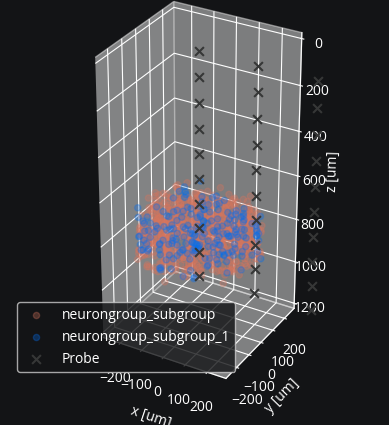

In [4]:
cleo.viz.plot(
    exc,
    inh,
    colors=[c["exc"], c["inh"]],
    zlim=(0, 1200),
    devices=[probe],
    scatterargs={"alpha": 0.3},
);

In [5]:
mua = ephys.MultiUnitSpiking(
    r_perfect_detection=0.05 * b2.mm,
    r_half_detection=0.1 * b2.mm,
)
ss = ephys.SortedSpiking(0.05 * b2.mm, 0.1 * b2.mm)
tklfp = ephys.TKLFPSignal()

There are a few important variations on how to record RWSLFP:
- Currents can be summed over the population, so that a postsynaptic current (PSC) in one location has the same effect on LFP as one on the other side of the population.
  The main advantage to this approach is it saves some memory storing currents.
  To use this, set {attr}`~cleo.ephys.RWSLFPSignalBase.pop_aggregate` to `True`.
  You'll also want to set {attr}`~cleo.ephys.RWSLFPSignalBase.amp_func` to `wslfp.mazzoni15_pop` to get the population amplitude profile from Mazzoni et al., 2015.
  The default is to not sum over the population, and use `wslfp.mazzoni15_nrn` to get per-neuron contributions to LFP instead.
- The LFP can be computed from PSCs if your model simulates them or from spikes (after synthesizing PSCs from them).
  Use {class}`~cleo.ephys.RWSLFPSignalFromSpikes` or {class}`~cleo.ephys.RWSLFPSignalFromPSCs` accordingly.
  In this example, we are simulating synaptic dynamics in the form of biexponential currents, which happens to be the form used to generate synthetic PSCs.

{class}`~cleo.ephys.RWSLFPSignalFromSpikes` needs to know about all spikes transmitted to the population being recorded from, so `ampa_syns` and `gaba_syns` must be passed on injection.
To account for the relative impact of incoming spikes on synaptic currents, Cleo needs to be able to find the weight as well.
It looks for a variable or parameter named `w` in the synapses by default, but you can pass in an alternate name or a value on injection instead.

{class}`~cleo.ephys.RWSLFPSignalFromSpikes` has sensible defaults, but can be overridden with the exact parameters used in our model.
These are used in the synthetic current generation process.
These parameters then serve as the default for the signal, which can be overridden on a per-injection basis.

In [6]:
import wslfp

rwslfp_spk_nrn = ephys.RWSLFPSignalFromSpikes(
    tau1_ampa=exc_synapses.namespace["tau_dsyn"],
    tau2_ampa=exc_synapses.namespace["tau_rsyn"],
    tau1_gaba=inh_synapses.namespace["tau_dsyn"],
    tau2_gaba=inh_synapses.namespace["tau_rsyn"],
    syn_delay=synaptic_delay,
    name="per-neuron RWSLFP from spikes",
)

rwslfp_spk_pop = ephys.RWSLFPSignalFromSpikes(
    pop_aggregate=True,
    amp_func=wslfp.mazzoni15_pop,
    name="population-aggregated RWSLFP from spikes",
)

All that's needed for {class}`~cleo.ephys.RWSLFPSignalFromPSCs` is `Iampa_var_names` and `Igaba_var_names` on injection, which are lists of the variables representing AMPA and GABA currents.

In [7]:
rwslfp_psc_nrn = ephys.RWSLFPSignalFromPSCs(name="per-neuron RWSLFP from PSCs")
rwslfp_psc_pop = ephys.RWSLFPSignalFromPSCs(
    pop_aggregate=True,
    amp_func=wslfp.mazzoni15_pop,
    name="population-aggregated RWSLFP from PSCs",
)

All signals are grouped together on the probe, but we can avoid RWSLFP being recorded from interneurons by omitting `ampa_syns`, `gaba_syns`, `Iampa_var_names`, and `Igaba_var_names` from the injection.

In [8]:
probe.add_signals(
    mua,
    ss,
    tklfp,
    rwslfp_spk_nrn,
    rwslfp_spk_pop,
    rwslfp_psc_nrn,
    rwslfp_psc_pop,
)

sim.set_io_processor(cleo.ioproc.RecordOnlyProcessor(sample_period_ms=1))
sim.inject(
    probe,
    exc,
    # for TKLFPSignal:
    tklfp_type="exc",
    # for RWSLFPSignalFromSpikes:
    synaptic_delay=synaptic_delay,  # can override for all synapses
    ampa_syns=[  # or per synapse by with (syn, kwargs) tuples:
        # want only synapses onto pyramidal cells
        (exc_synapses[f"j < {n_exc}"], {"weight": J_excit}),
        (ext_synapses[f"j < {n_exc}"], {"weight": w_ext}),
    ],
    gaba_syns=[(inh_synapses[f"j < {n_exc}"], {"weight": J_inhib})],
    # for RWSLFPSignalFromPSCs:
    Iampa_var_names=["I_exc", "I_ext"],
    Igaba_var_names=["I_gaba"],
)
# we don't include ampa_syns, gaba_syns, Iampa_var_name, or Igaba_var_name since RWSLFP
# is only recorded from pyramidal cells
sim.inject(probe, inh, tklfp_type="inh")

CLSimulator(io_processor=RecordOnlyProcessor(sample_period_ms=1, sampling='fixed', processing='parallel'), devices={Probe(name='Probe', save_history=True, signals=[MultiUnitSpiking(name='MultiUnitSpiking', brian_objects={<SpikeMonitor, recording from 'spikemonitor_9'>, <SpikeMonitor, recording from 'spikemonitor'>}, probe=..., r_perfect_detection=50. * umetre, r_half_detection=100. * umetre, cutoff_probability=0.01), SortedSpiking(name='SortedSpiking', brian_objects={<SpikeMonitor, recording from 'spikemonitor_10'>, <SpikeMonitor, recording from 'spikemonitor_1'>}, probe=..., r_perfect_detection=50. * umetre, r_half_detection=100. * umetre, cutoff_probability=0.01), TKLFPSignal(name='TKLFPSignal', brian_objects={<SpikeMonitor, recording from 'spikemonitor_11'>, <SpikeMonitor, recording from 'spikemonitor_2'>}, probe=..., uLFP_threshold_uV=0.001), RWSLFPSignalFromSpikes(name='per-neuron RWSLFP from spikes', brian_objects={<SpikeMonitor, recording from 'spikemonitor_3'>, <SpikeMonitor, r

In [9]:
sim.reset()
sim.run(500 * b2.ms)

INFO       No numerical integration method specified for group 'synapses_1', using method 'exact' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'exact' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.00s). [brian2.stateupdaters.base.method_choice]


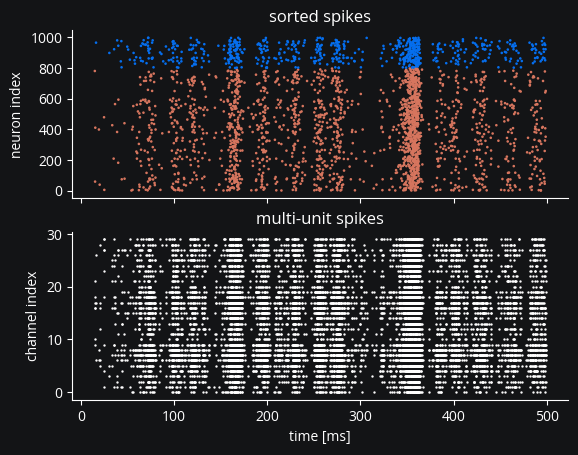

In [10]:
from matplotlib.colors import ListedColormap

fig, axs = plt.subplots(2, 1, sharex=True)

# assuming all neurons are detectable for c=ss.i >= n_e to work
# in practice this will often not be the case and we'd have to map
# from probe index to neuron group index using ss.i_probe_by_i_ng.inverse
exc_inh_cmap = ListedColormap([c["exc"], c["inh"]])
axs[0].scatter(ss.t_ms, ss.i, marker=".", c=ss.i >= n_exc, cmap=exc_inh_cmap, s=3)
axs[0].set(title="sorted spikes", ylabel="neuron index")

axs[1].scatter(mua.t_ms, mua.i, marker=".", s=2, c="white")
axs[1].set(title="multi-unit spikes", ylabel="channel index", xlabel="time [ms]");

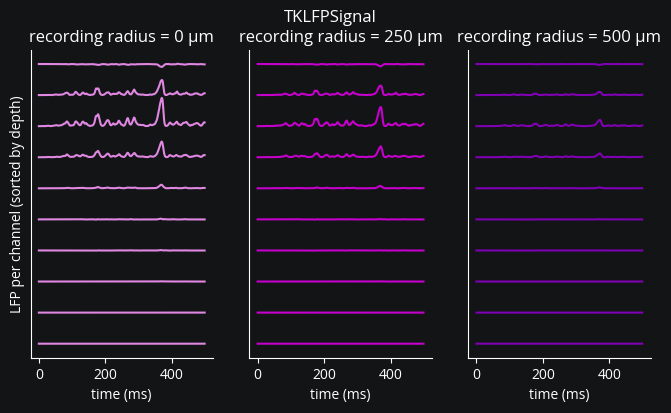

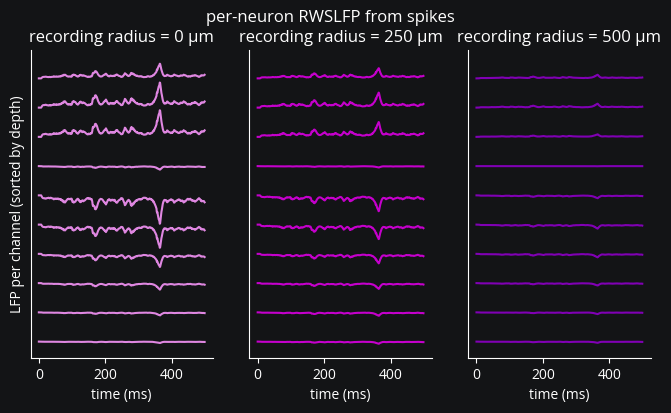

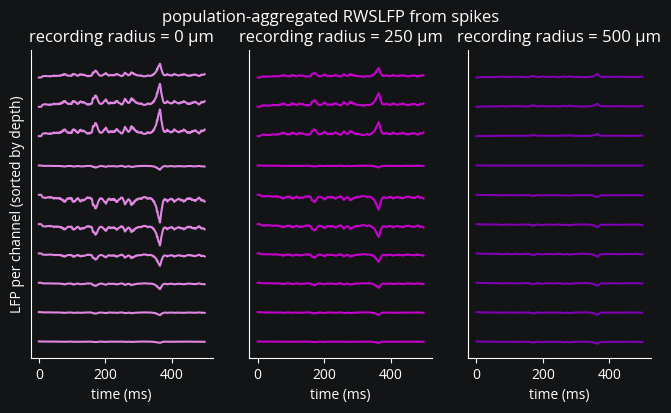

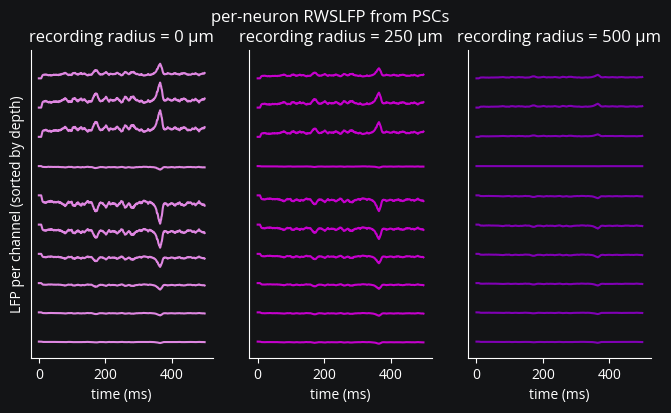

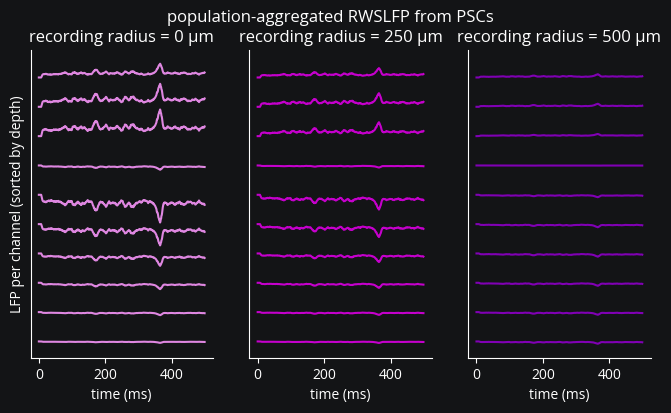

In [17]:
def plot_lfp(t_ms, lfp, title=None):
    n_shanks = 3
    n_contacts_per_shank = 10
    fig, axs = plt.subplots(1, n_shanks, sharey=True, figsize=(8, 4))
    for i, color, r_rec, ax in zip(
        range(n_shanks), [c["light"], c["main"], c["dark"]], [0, 250, 500], axs
    ):
        lfp_for_shank = lfp[
            :, i * n_contacts_per_shank : (i + 1) * n_contacts_per_shank
        ]
        ax.plot(
            t_ms,
            lfp_for_shank + np.arange(n_contacts_per_shank) * 1.1 * np.abs(lfp.max()),
            c=color,
        )
        ax.set(xlabel="time (ms)", yticks=[], title=f"recording radius = {r_rec} µm")

    axs[0].set(ylabel="LFP per channel (sorted by depth)")
    if title:
        fig.suptitle(title)


for signal in probe.signals:
    if isinstance(signal, ephys.TKLFPSignal):
        lfp = signal.lfp_uV
    elif isinstance(signal, (ephys.RWSLFPSignalFromPSCs, ephys.RWSLFPSignalFromSpikes)):
        lfp = signal.lfp
    else:
        continue
    plot_lfp(signal.t_ms, lfp, title=signal.name)

Despite using all the same parameters for the postsynaptic current curves, the `FromSpikes` and `FromPSCs` signals look different.
In fact, what we see above matches the [WSLFP demo](https://github.com/siplab-gt/wslfp#synthesizing-currents-from-spikes), where the spike convolution signal is somewhat spikier (i.e., with higher peaks the jump at the beginning looks smaller).